In [1]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy as sp

from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import mahalanobis
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

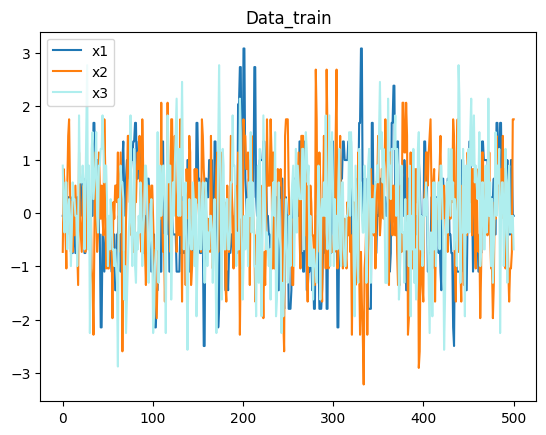

In [2]:
# Read train data
filepath = 'https://raw.githubusercontent.com/iraola/te-orig-fortran/main/datasets/braatz_anomaly_detection/train/d00.csv'
data_train = pd.read_csv(filepath)
data_train_np = data_train.values

# Normalize and plot train data
scaler = StandardScaler()

Data_train_nolabel = scaler.fit_transform(data_train_np[:,0:-1])
label_train = data_train_np[:,-1]
label_train = label_train.reshape((len(label_train), 1))
Data_train = np.concatenate((Data_train_nolabel, label_train), axis=1)
Data_train_df = pd.DataFrame(Data_train)
Data_train_df.columns = data_train.columns

x_axis_train = np.linspace(0, len(data_train), len(data_train))
plt.plot(x_axis_train, Data_train[:,0:2])
plt.plot(x_axis_train, Data_train[:,2], color='paleturquoise')
plt.title("Data_train")
plt.legend(labels=["x1","x2","x3"])
plt.show()

# Calculate mean and standard deviation of train data
data_train_mean = pd.DataFrame(columns=['mu' + str(j) for j in range(1, len(Data_train_df.columns))])
data_train_std = pd.DataFrame(columns=['sigma' + str(j) for j in range(1, len(Data_train_df.columns))])

n = 1 # number of data each sample
gap = 1 # gap between each sample

# Loop over the data and add rows to the DataFrame
for i in range(0, len(Data_train)-n+1, gap):
    # Calculate the mean for each column of the current sample
    sample_mean = [Data_train[i:i+n,k].mean() for k in range(len(Data_train_df.columns)-1)]
    # Add the new row of means to the DataFrame
    data_train_mean.loc[i] = sample_mean
# Reset the index to a simple integer index
data_train_mean = data_train_mean.reset_index(drop=True)

# Do the same thing for std
for i in range(0, len(Data_train)-n+1, gap):
    sample_std = [Data_train[i:i+n,k].std() for k in range(52)]
    data_train_std.loc[i] = sample_std
data_train_std = data_train_std.reset_index(drop=True)

# Combine mean and std into a dataframe
Data_train_mean_std = pd.concat([data_train_mean, data_train_std], axis=1)


In [3]:
# Use Kmeans to find the centroid based on train data
# choose the number of clusters (k)
k = 1
# initialize the KMeans object with k clusters
kmeans = KMeans(n_clusters=k, random_state=0)
# fit the KMeans model to the data
kmeans.fit(Data_train_mean_std)
# get the centroid locations for each cluster
centroids = kmeans.cluster_centers_

# Compute the Mahalanobis distance between each normal data point and the cluster centers
distances_train = []
for i in range(Data_train_mean_std.shape[0]):
    points_cov = [centroids[0], Data_train_mean_std.iloc[i]]
    cov = np.cov(points_cov, rowvar=False) # calculate the covariance matrix
    distances_train.append(mahalanobis(Data_train_mean_std.iloc[i], centroids[0], cov))
print(distances_train)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[12.868851868261649, 21.813434997823347, 24.351091709442358, 16.42286747192715, 18.607766854078353, 25.439586684243135, 18.243606875393205, 26.489338384377003, 24.56154823945877, 25.191347932081296, 26.330141409319204, 32.56487499958823, 21.002673371891937, 28.8942696723093, 24.607646645444003, 26.16672442693332, 26.821842339082032, 26.995546959687264, 31.65875583651189, 23.09164676798404, 22.1134609095797, 26.91891844849746, 28.558167789837913, 25.541482381281597, 32.008491481092264, 29.34737398157343, 29.67820716846746, 28.89642993804855, 27.270789128323344, 22.44575243947806, 20.730103896546115, 20.713448549154762, 34.71304755413271, 37.8675298248077, 37.87194334395381, 44.702193358154446, 24.65963367925568, 32.186097106064054, 34.448665266695215, 40.43853153638304, 36.40280789084723, 31.16995916432101, 30.679712088564383, 33.260736094457364, 29.060395170393768, 30.588647875290242, 31.924809481431886, 33.76062492702512, 31.257517942505956, 35.046906360025126, 30.208408181098985, 32.

In [4]:
# Bisection method to tune the threshold
lower_bound = 0
upper_bound = max(distances_train)

tolerance = 0.001  # Tolerance level for accuracy
desired_accuracy = 0.99
while upper_bound - lower_bound > tolerance:
    # Calculate the current threshold
    current_threshold = (lower_bound + upper_bound) / 2

    # Find the indices of anomalies based on the current threshold
    anomalies_tuning = np.where(np.array(distances_train) > current_threshold)[0]
    anomalies_tuning = anomalies_tuning + n - 1

    # Create predicted labels based on anomalies
    y_pred_np_train = np.zeros(len(data_train), dtype=bool)
    y_pred_np_train[anomalies_tuning] = True
    y_pred_train = pd.DataFrame(y_pred_np_train)
    y_true_train = Data_train_df['label']

    # Calculate the accuracy based on the predicted and true labels
    accuracy_train = accuracy_score(y_true_train, y_pred_train)

    if accuracy_train == desired_accuracy:
        # The accuracy threshold is met
        threshold = current_threshold
        break
    elif accuracy_train > desired_accuracy:
        # Decrease the threshold
        upper_bound = current_threshold
    else:
        # Increase the threshold
        lower_bound = current_threshold

print("Tuned threshold:", threshold)
print("Achieved training accuracy:", accuracy_train)


Tuned threshold: 61.99097159509219
Achieved training accuracy: 0.99


In [5]:
# Import test data
csv_files = ['https://raw.githubusercontent.com/iraola/te-orig-fortran/main/datasets/braatz_anomaly_detection/test/d00.csv',
             'https://raw.githubusercontent.com/iraola/te-orig-fortran/main/datasets/braatz_anomaly_detection/test/d01.csv',
             'https://raw.githubusercontent.com/iraola/te-orig-fortran/main/datasets/braatz_anomaly_detection/test/d02.csv',
             'https://raw.githubusercontent.com/iraola/te-orig-fortran/main/datasets/braatz_anomaly_detection/test/d03.csv',
             'https://raw.githubusercontent.com/iraola/te-orig-fortran/main/datasets/braatz_anomaly_detection/test/d04.csv',
             'https://raw.githubusercontent.com/iraola/te-orig-fortran/main/datasets/braatz_anomaly_detection/test/d05.csv',
             'https://raw.githubusercontent.com/iraola/te-orig-fortran/main/datasets/braatz_anomaly_detection/test/d06.csv',
             'https://raw.githubusercontent.com/iraola/te-orig-fortran/main/datasets/braatz_anomaly_detection/test/d07.csv',
             'https://raw.githubusercontent.com/iraola/te-orig-fortran/main/datasets/braatz_anomaly_detection/test/d08.csv',
             'https://raw.githubusercontent.com/iraola/te-orig-fortran/main/datasets/braatz_anomaly_detection/test/d09.csv',
             'https://raw.githubusercontent.com/iraola/te-orig-fortran/main/datasets/braatz_anomaly_detection/test/d10.csv',
             'https://raw.githubusercontent.com/iraola/te-orig-fortran/main/datasets/braatz_anomaly_detection/test/d11.csv',
             'https://raw.githubusercontent.com/iraola/te-orig-fortran/main/datasets/braatz_anomaly_detection/test/d12.csv',
             'https://raw.githubusercontent.com/iraola/te-orig-fortran/main/datasets/braatz_anomaly_detection/test/d13.csv',
             'https://raw.githubusercontent.com/iraola/te-orig-fortran/main/datasets/braatz_anomaly_detection/test/d14.csv',
             'https://raw.githubusercontent.com/iraola/te-orig-fortran/main/datasets/braatz_anomaly_detection/test/d15.csv',
             'https://raw.githubusercontent.com/iraola/te-orig-fortran/main/datasets/braatz_anomaly_detection/test/d16.csv',
             'https://raw.githubusercontent.com/iraola/te-orig-fortran/main/datasets/braatz_anomaly_detection/test/d17.csv',
             'https://raw.githubusercontent.com/iraola/te-orig-fortran/main/datasets/braatz_anomaly_detection/test/d18.csv',
             'https://raw.githubusercontent.com/iraola/te-orig-fortran/main/datasets/braatz_anomaly_detection/test/d19.csv',
             'https://raw.githubusercontent.com/iraola/te-orig-fortran/main/datasets/braatz_anomaly_detection/test/d20.csv',
             'https://raw.githubusercontent.com/iraola/te-orig-fortran/main/datasets/braatz_anomaly_detection/test/d21.csv']

# Empty list to store the dataframes
dfs = []
# Empty dataframe to store test performance of different datasets
Test_performance = pd.DataFrame(columns=['Test accuracy', 'Test precision', 'Test recall', 'Test F1 score'])

for file in csv_files:
    # Read the CSV file into a dataframe
    df = pd.read_csv(file)
    # Append the dataframe to the list
    dfs.append(df)

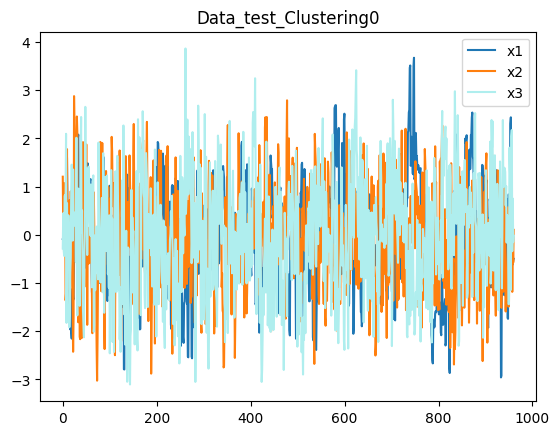

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
<ipython-input-6-b928776b5699>:72: FutureWarning: The frame.append method is deprecated and will be removed fro

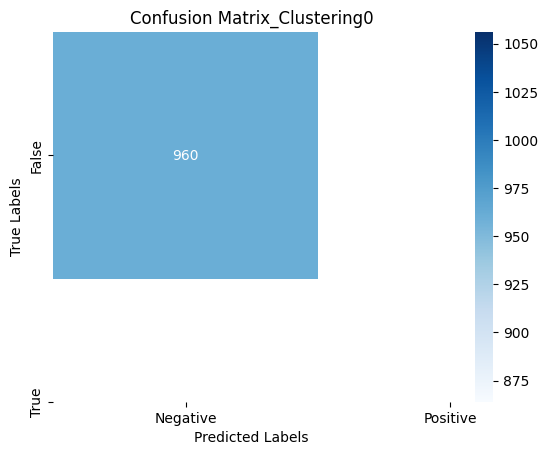

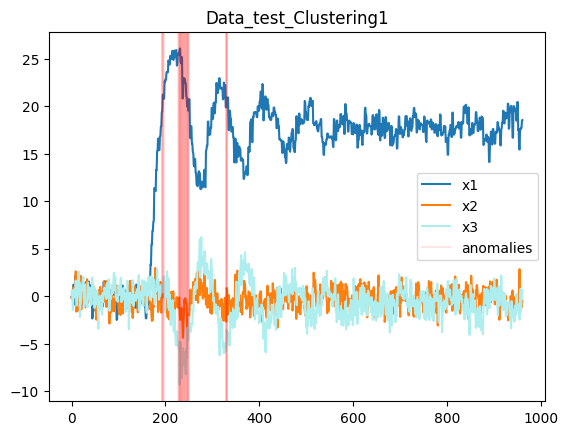

<ipython-input-6-b928776b5699>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test_performance = Test_performance.append(new_row, ignore_index=True)


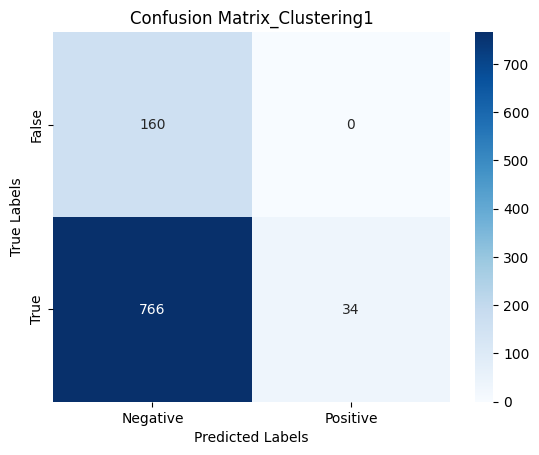

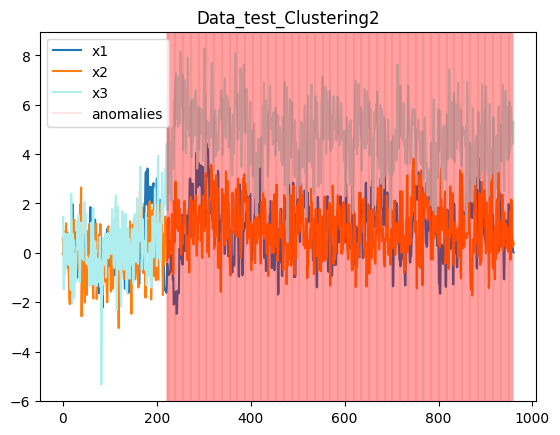

<ipython-input-6-b928776b5699>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test_performance = Test_performance.append(new_row, ignore_index=True)


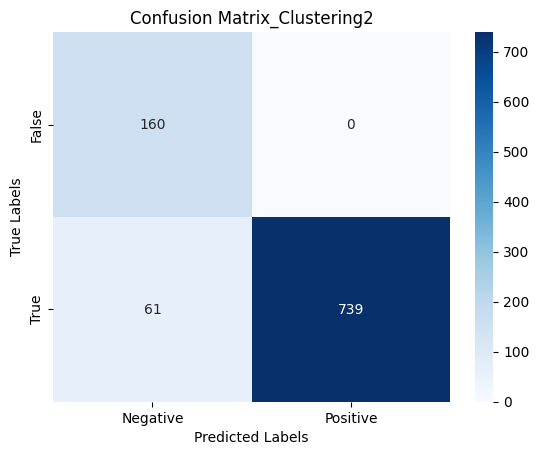

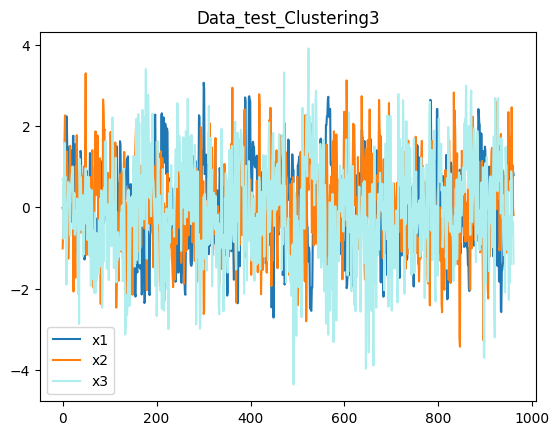

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-6-b928776b5699>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test_performance = Test_performance.append(new_row, ignore_index=True)


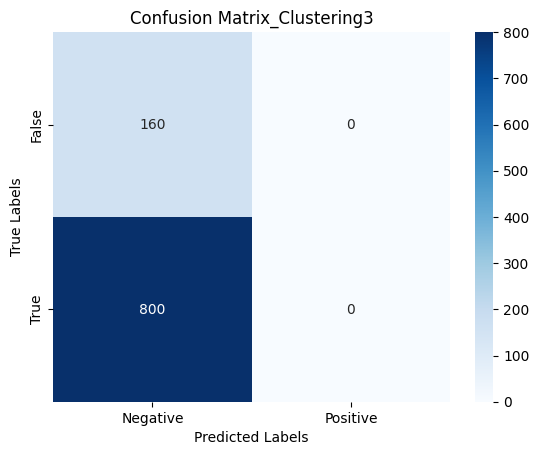

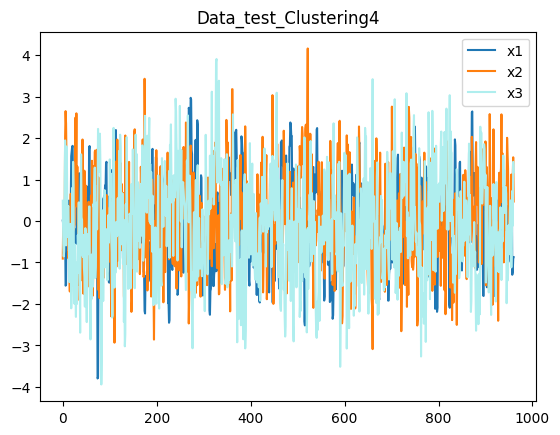

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-6-b928776b5699>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test_performance = Test_performance.append(new_row, ignore_index=True)


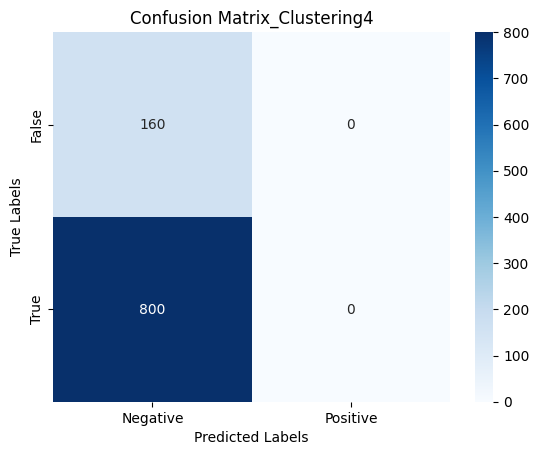

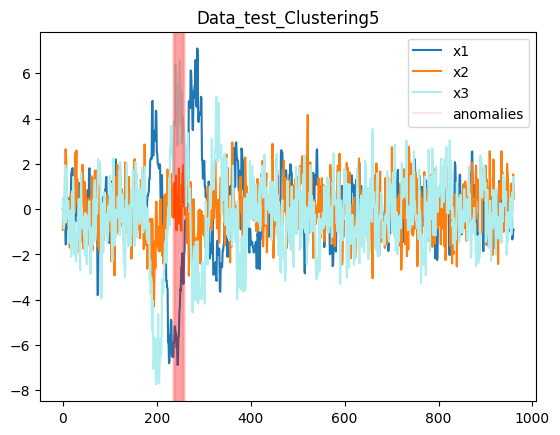

<ipython-input-6-b928776b5699>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test_performance = Test_performance.append(new_row, ignore_index=True)


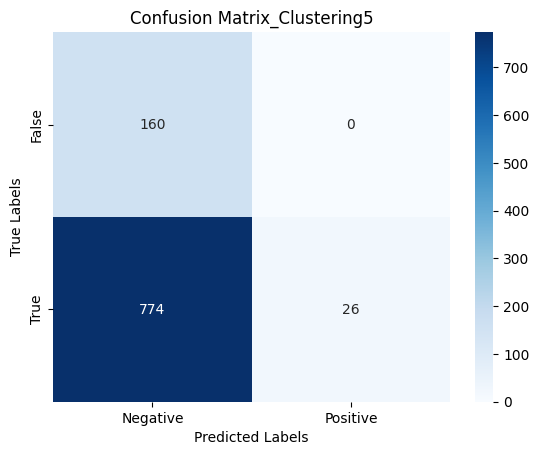

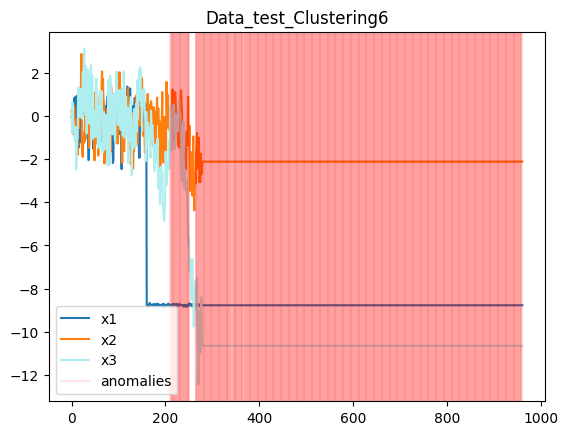

<ipython-input-6-b928776b5699>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test_performance = Test_performance.append(new_row, ignore_index=True)


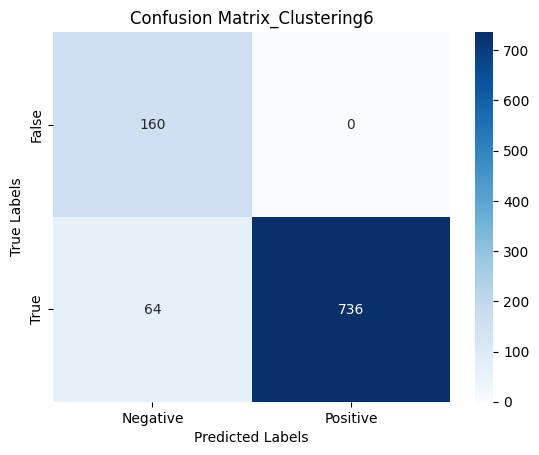

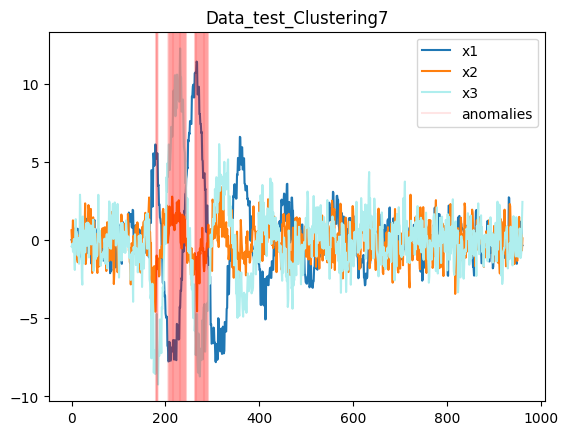

<ipython-input-6-b928776b5699>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test_performance = Test_performance.append(new_row, ignore_index=True)


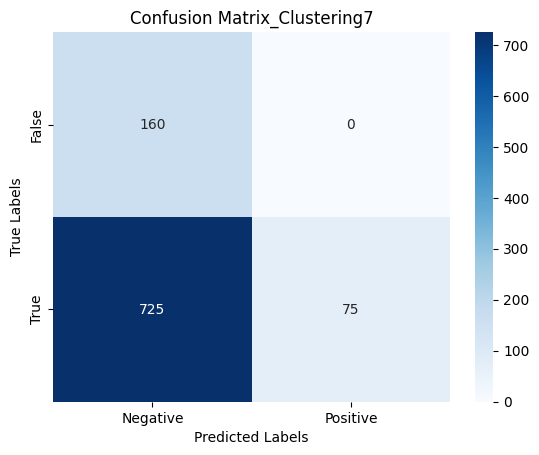

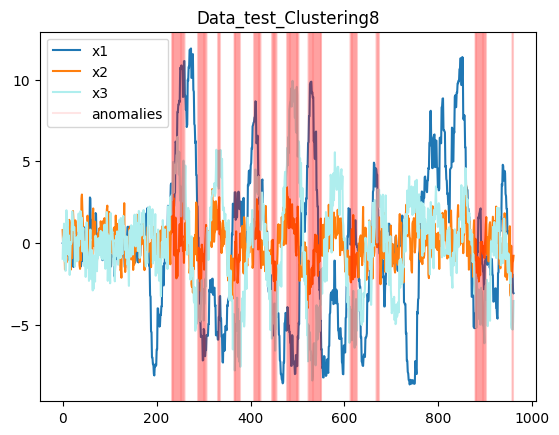

<ipython-input-6-b928776b5699>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test_performance = Test_performance.append(new_row, ignore_index=True)


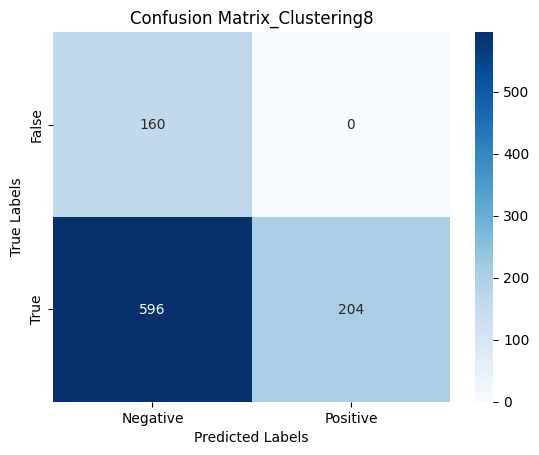

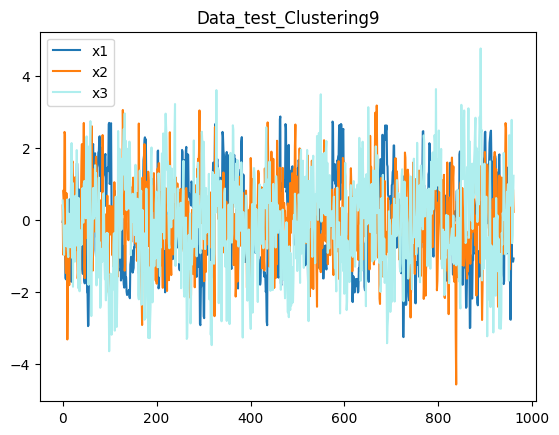

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-6-b928776b5699>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test_performance = Test_performance.append(new_row, ignore_index=True)


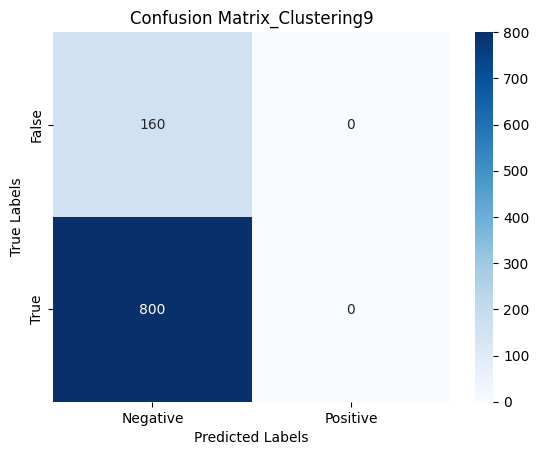

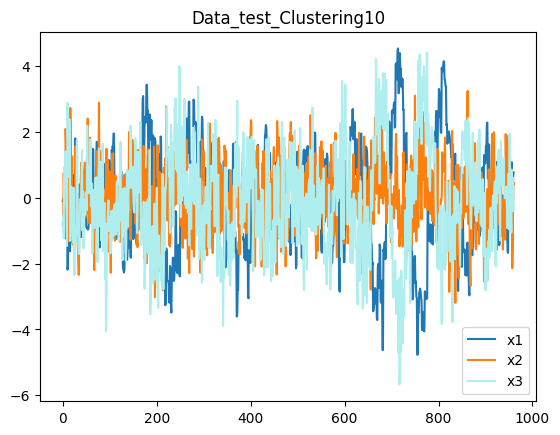

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-6-b928776b5699>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test_performance = Test_performance.append(new_row, ignore_index=True)


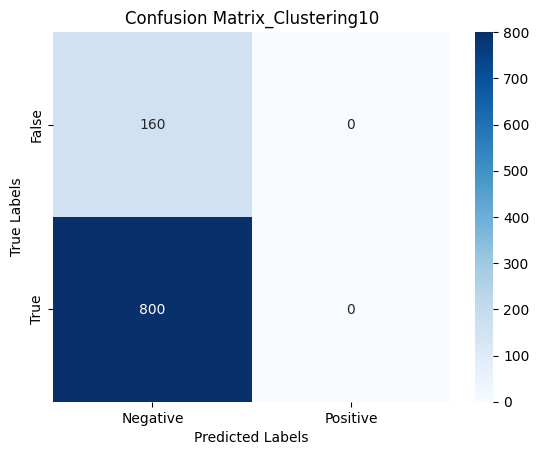

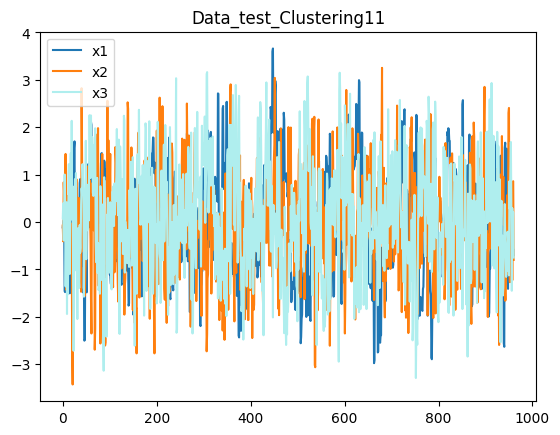

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-6-b928776b5699>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test_performance = Test_performance.append(new_row, ignore_index=True)


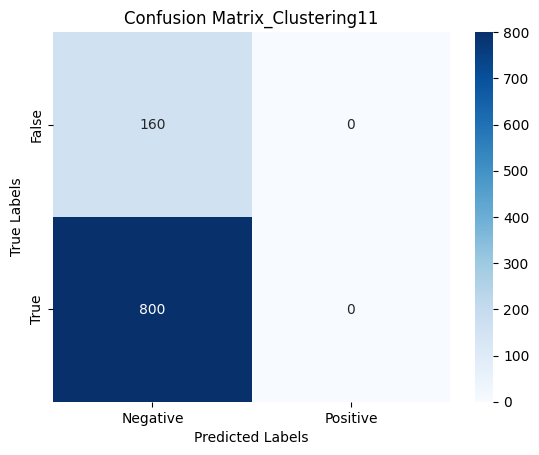

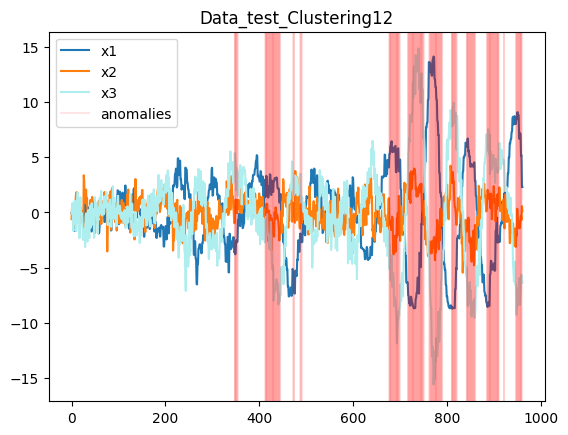

<ipython-input-6-b928776b5699>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test_performance = Test_performance.append(new_row, ignore_index=True)


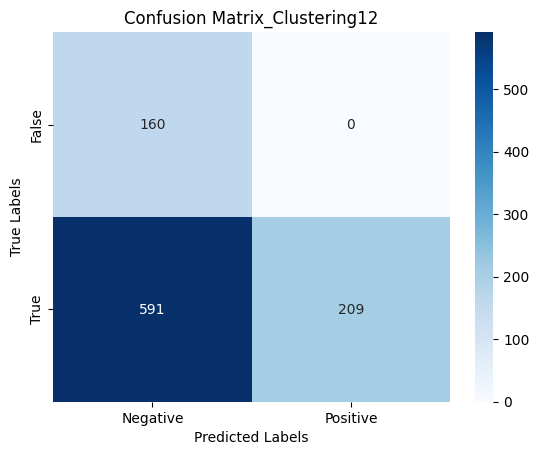

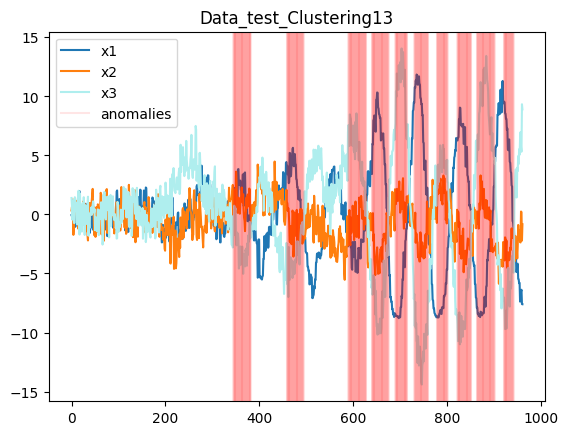

<ipython-input-6-b928776b5699>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test_performance = Test_performance.append(new_row, ignore_index=True)


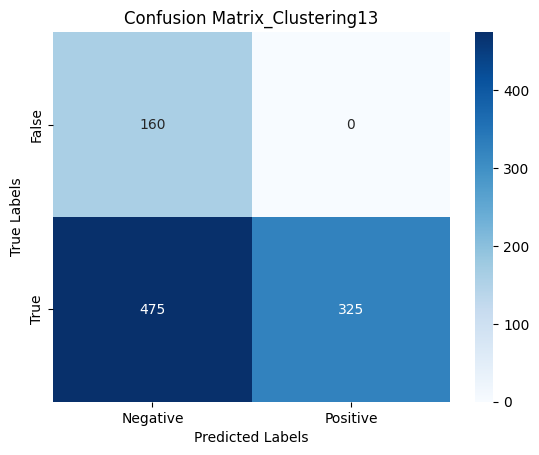

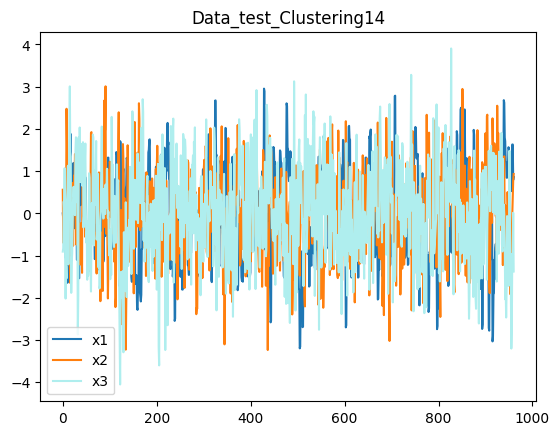

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-6-b928776b5699>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test_performance = Test_performance.append(new_row, ignore_index=True)


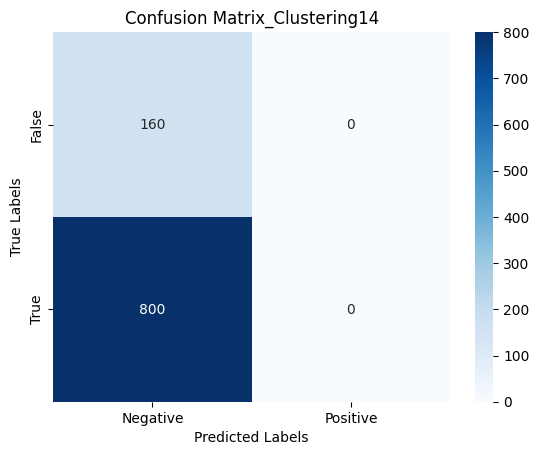

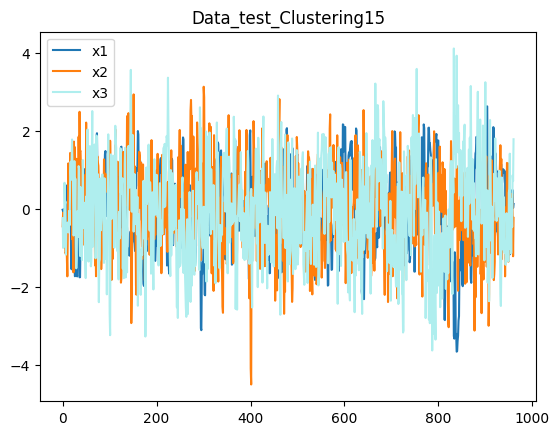

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-6-b928776b5699>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test_performance = Test_performance.append(new_row, ignore_index=True)


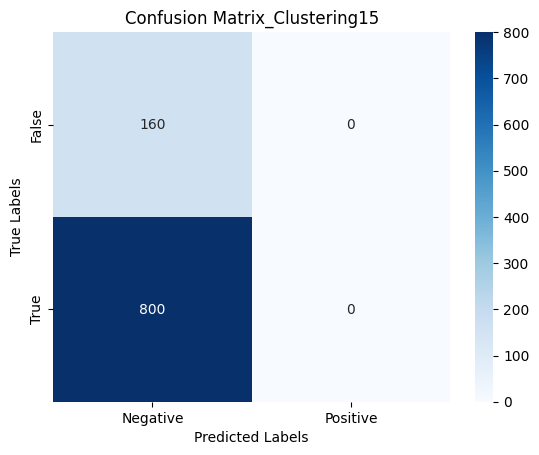

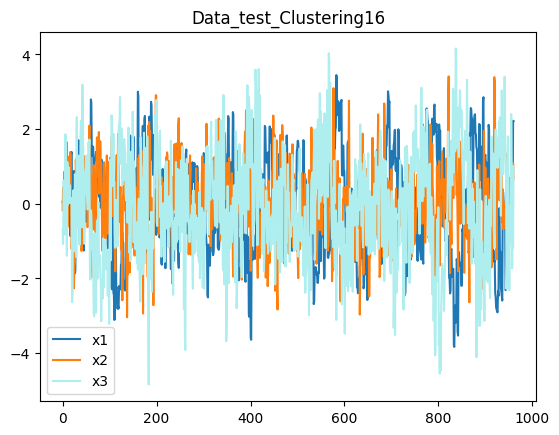

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-6-b928776b5699>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test_performance = Test_performance.append(new_row, ignore_index=True)


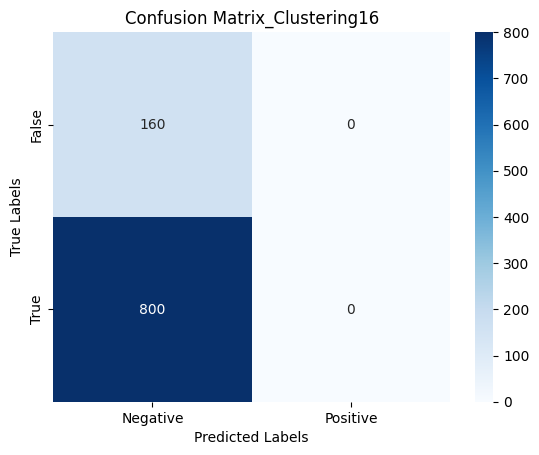

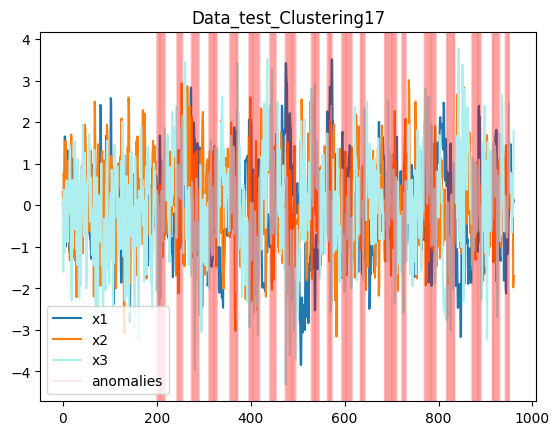

<ipython-input-6-b928776b5699>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test_performance = Test_performance.append(new_row, ignore_index=True)


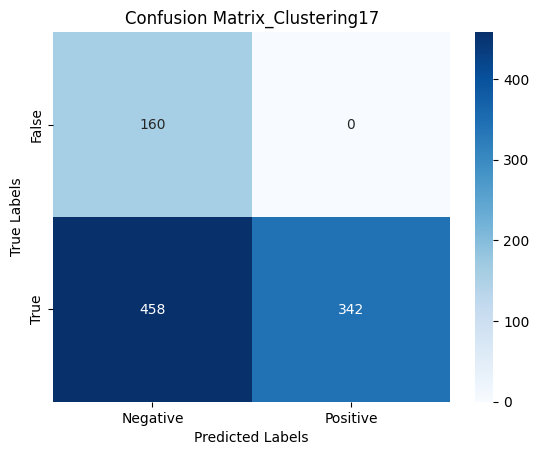

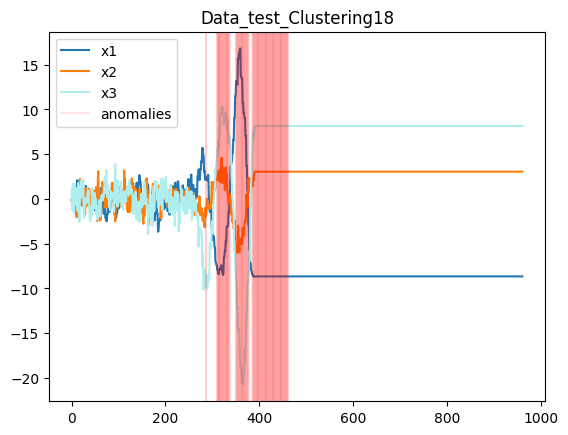

<ipython-input-6-b928776b5699>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test_performance = Test_performance.append(new_row, ignore_index=True)


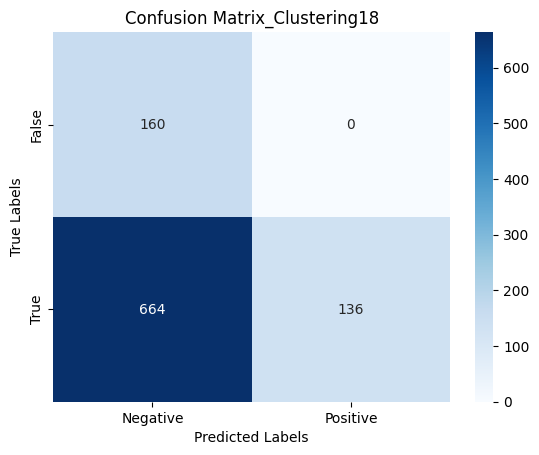

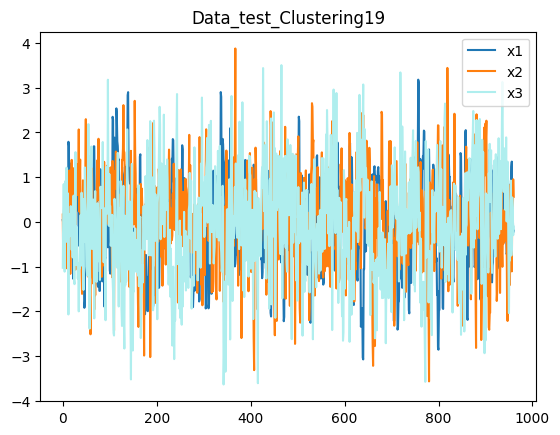

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-6-b928776b5699>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test_performance = Test_performance.append(new_row, ignore_index=True)


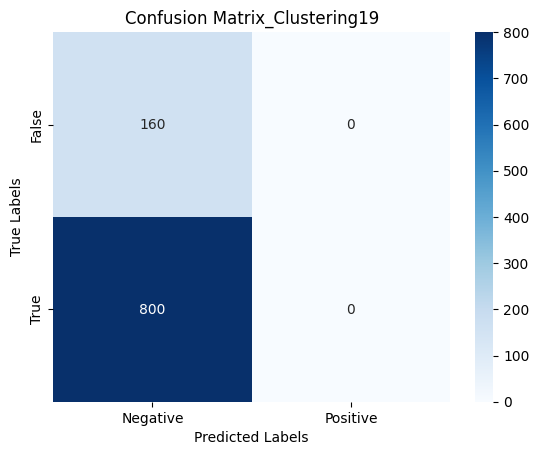

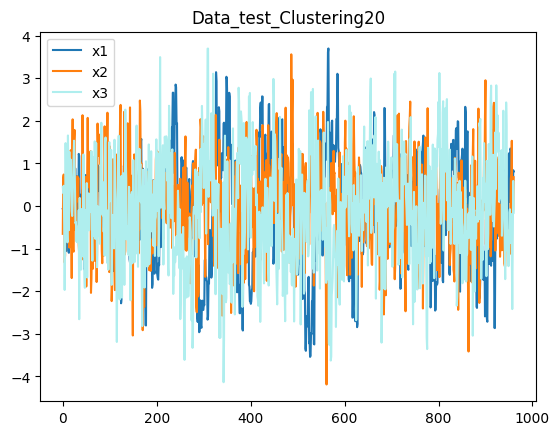

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-6-b928776b5699>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test_performance = Test_performance.append(new_row, ignore_index=True)


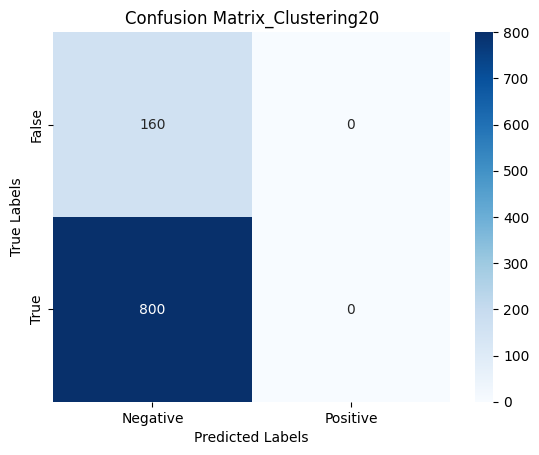

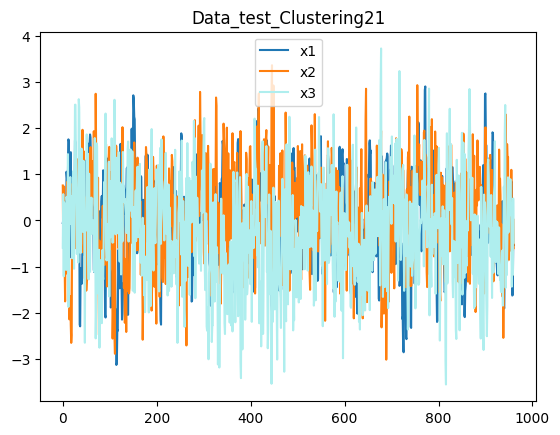

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-6-b928776b5699>:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Test_performance = Test_performance.append(new_row, ignore_index=True)


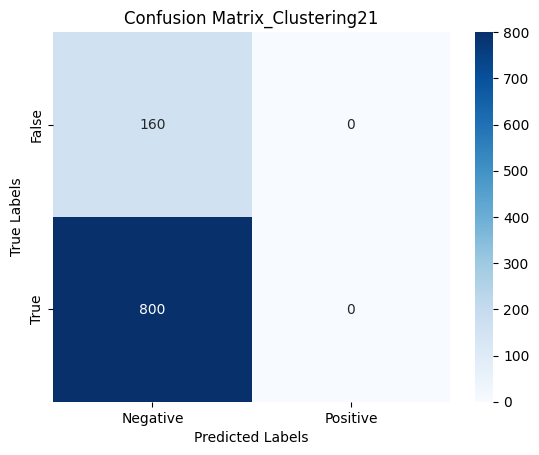

In [6]:
# Analyze the dataset one by one

y_pred_total = pd.DataFrame()
y_true_total = pd.DataFrame()

for data_index in range(22):
    data_test = dfs[data_index]
    data_test_np = data_test.values

    # Normalize and plot test data
    Data_test_nolabel = scaler.transform(data_test_np[:,0:52])
    label_test = data_test_np[:,52]
    label_test = label_test.reshape((len(label_test), 1))
    Data_test = np.concatenate((Data_test_nolabel, label_test), axis=1)
    Data_test_df = pd.DataFrame(Data_test)
    Data_test_df.columns = data_test.columns

    # Calculate mean and standard deviation for data test
    n = 10 # number of data each sample
    gap = 1 # gap between each sample
    data_test_mean = pd.DataFrame(columns=['mu' + str(j) for j in range(1, 53)])
    data_test_std = pd.DataFrame(columns=['sigma' + str(j) for j in range(1, 53)])
    for i in range(0, len(Data_test)-n+1, gap):
        sample_mean = [Data_test[i:i+n,k].mean() for k in range(52)]
        data_test_mean.loc[i] = sample_mean
    data_test_mean = data_test_mean.reset_index(drop=True)
    for i in range(0, len(Data_test)-n+1, gap):
        sample_std = [Data_test[i:i+n,k].std() for k in range(52)]
        data_test_std.loc[i] = sample_std
    data_test_std = data_test_std.reset_index(drop=True)
    Data_test_mean_std = pd.concat([data_test_mean, data_test_std], axis=1)

    # Anomaly detection
    # Compute the Mahalanobis distance between each data point (with anomaly) and the cluster centers of train data
    distances_test = []
    for i in range(Data_test_mean_std.shape[0]):
        distances_test.append(mahalanobis(Data_test_mean_std.iloc[i], centroids[0], cov))

    anomalies_sample = np.where(np.array(distances_test) > threshold)[0]
    anomalies = anomalies_sample+n-1

    # visualize the result
    x_axis_test = np.linspace(0, len(data_test), len(data_test))
    plt.plot(x_axis_test, Data_test[:,0:2])
    plt.plot(x_axis_test, Data_test[:,2], color='paleturquoise')
    for line in anomalies:
        plt.axvline(x=line, color='r', alpha=0.1)
    plt.title('Data_test_Clustering' + str(data_index))
    plt.legend(labels=['x1','x2','x3','anomalies'])
    plt.show()


    ## Test the performance
    # Store predictions as '1' and '0'; or 'True' and 'False'
    y_pred_np = np.zeros(len(data_test), dtype=bool)
    y_pred_np[anomalies] = True
    y_pred = pd.DataFrame(y_pred_np)
    y_true = Data_test_df['label'].apply(lambda x: 1 if x != 0 else x)


    y_pred_total = pd.concat([y_pred_total, y_pred], axis=0)
    y_true_total = pd.concat([y_true_total, y_true], axis=0)


    accuracy_test = accuracy_score(y_true, y_pred)
    precision_test = precision_score(y_true, y_pred)
    recall_test = recall_score(y_true, y_pred)
    f1_test = f1_score(y_true, y_pred)
    # Create a new row as a dictionary
    new_row = {'Test accuracy': accuracy_test, 'Test precision': precision_test, 'Test recall': recall_test, 'Test F1 score': f1_test}
    Test_performance = Test_performance.append(new_row, ignore_index=True)

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Define the labels for the matrix
    x_labels = ['Negative','Positive']
    y_labels = ['False','True']
    # Create a heatmap visualization of the confusion matrix
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=x_labels, yticklabels=y_labels)
    # Add labels to the plot
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix_Clustering' + str(data_index))
    # Show the plot
    plt.show()


In [7]:
Test_performance

,Test accuracy,Test precision,Test recall,Test F1 score
0,1.000000,0.0,0.00000,0.000000
1,0.202083,1.0,0.04250,0.081535
2,0.936458,1.0,0.92375,0.960364
3,0.166667,0.0,0.00000,0.000000
4,0.166667,0.0,0.00000,0.000000
5,0.193750,1.0,0.03250,0.062954
6,0.933333,1.0,0.92000,0.958333
7,0.244792,1.0,0.09375,0.171429
8,0.379167,1.0,0.25500,0.406375
9,0.166667,0.0,0.00000,0.000000


0.33835227272727275
1.0
0.1682142857142857
0.28798532558850504


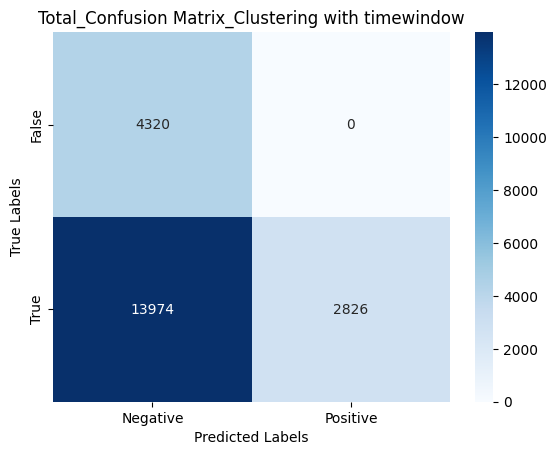

In [8]:
y_pred_total = y_pred_total.reset_index(drop=True)
y_true_total = y_true_total.reset_index(drop=True)

accuracy_test_total = accuracy_score(y_true_total, y_pred_total)
precision_test_total = precision_score(y_true_total, y_pred_total)
recall_test_total = recall_score(y_true_total, y_pred_total)
f1_test_total = f1_score(y_true_total, y_pred_total)

print(accuracy_test_total)
print(precision_test_total)
print(recall_test_total)
print(f1_test_total)

# Compute the confusion matrix
cm = confusion_matrix(y_true_total, y_pred_total)
# Define the labels for the matrix
x_labels = ['Negative','Positive']
y_labels = ['False','True']
# Create a heatmap visualization of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=x_labels, yticklabels=y_labels)
# Add labels to the plot
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Total_Confusion Matrix_Clustering without timewindow')
# Show the plot
plt.show()
